In [1]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
from collections import Counter
from PIL import Image
import random

In [6]:
# Change this path to your dataset location
dataset_path = Path("./crop-pests-dataset")
dataset_path = dataset_path.resolve()
dataset_path

WindowsPath('D:/tracking/AgriPest/crop-pests-dataset')

In [7]:
# Display the directory structure
for root, dirs, files in os.walk(dataset_path):
    level = root.replace(str(dataset_path), '').count(os.sep)
    indent = ' ' * 4 * level
    print(f"{indent}{os.path.basename(root)}/")
    sub_indent = ' ' * 4 * (level + 1)
    for f in files[:2]:  # show only first 2 per folder
        print(f"{sub_indent}{f}")

crop-pests-dataset/
    data.yaml
    test/
        images/
            ants-112-_jpg.rf.b8d6b9acf9fa1edfb438381cbae99199.jpg
            ants-122-_jpg.rf.4819e9d7a1531a8b3a430c66b0c4c4bf.jpg
        labels/
            ants-112-_jpg.rf.b8d6b9acf9fa1edfb438381cbae99199.txt
            ants-122-_jpg.rf.4819e9d7a1531a8b3a430c66b0c4c4bf.txt
    train/
        images/
            ants-1-_jpg.rf.8227b4d5f1cbbd72c290c1ca6012a337.jpg
            ants-1-_jpg.rf.cb38695892dc2ca4d3ee97d3f8a06ba7.jpg
        labels/
            ants-1-_jpg.rf.8227b4d5f1cbbd72c290c1ca6012a337.txt
            ants-1-_jpg.rf.cb38695892dc2ca4d3ee97d3f8a06ba7.txt
    valid/
        images/
            ants-10-_jpg.rf.f937cb3b8cb66ee07a190747d239c00b.jpg
            ants-102-_jpg.rf.55777d3cfd1c0c3598217f42575dface.jpg
        labels/
            ants-10-_jpg.rf.f937cb3b8cb66ee07a190747d239c00b.txt
            ants-102-_jpg.rf.55777d3cfd1c0c3598217f42575dface.txt


In [8]:
# Count images and labels across train / val / test folders

splits = ["train", "valid", "test"]
image_extensions = (".jpg", ".jpeg", ".png")

for split in splits:
    images_path = dataset_path / split / "images"
    labels_path = dataset_path / split / "labels"

    images = [f for f in os.listdir(images_path) if f.lower().endswith(image_extensions)]
    labels = [f for f in os.listdir(labels_path) if f.lower().endswith(".txt")]

    print(f"\n📁 Dataset Split: {split}")
    print(f"  Total Images     : {len(images)}")
    print(f"  Total Labels     : {len(labels)}")
    print(f"  Label Coverage   : {round(len(labels) / len(images) * 100, 2)} %")



📁 Dataset Split: train
  Total Images     : 11502
  Total Labels     : 11502
  Label Coverage   : 100.0 %

📁 Dataset Split: valid
  Total Images     : 1095
  Total Labels     : 1095
  Label Coverage   : 100.0 %

📁 Dataset Split: test
  Total Images     : 546
  Total Labels     : 546
  Label Coverage   : 100.0 %


In [9]:
total_images = 0
total_labels = 0

for split in splits:
    images_path = dataset_path / split / "images"
    labels_path = dataset_path / split / "labels"

    images = [f for f in os.listdir(images_path) if f.lower().endswith(image_extensions)]
    labels = [f for f in os.listdir(labels_path) if f.lower().endswith(".txt")]

    total_images += len(images)
    total_labels += len(labels)

print("OVERALL DATASET SUMMARY")
print("  Total Images :", total_images)
print("  Total Labels :", total_labels)
print("  Overall Coverage :", round(total_labels / total_images * 100, 2), "%")


OVERALL DATASET SUMMARY
  Total Images : 13143
  Total Labels : 13143
  Overall Coverage : 100.0 %


In [10]:
def show_random_image_with_bbox(split):
    images_path = dataset_path / split / "images"
    labels_path = dataset_path / split / "labels"

    images = [f for f in os.listdir(images_path) if f.lower().endswith(image_extensions)]
    random_image = random.choice(images)

    img_path = images_path / random_image
    
    # ✅ Fix applied here
    label_filename = random_image.rsplit(".", 1)[0] + ".txt"
    label_path = labels_path / label_filename

    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    h, w, _ = img.shape

    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            for line in f.readlines():
                cls, x_center, y_center, width, height = map(float, line.split())
                x1 = int((x_center - width / 2) * w)
                y1 = int((y_center - height / 2) * h)
                x2 = int((x_center + width / 2) * w)
                y2 = int((y_center + height / 2) * h)
                cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)

    plt.figure(figsize=(8,8))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Random Image from {split} (with bounding boxes)")
    plt.show()

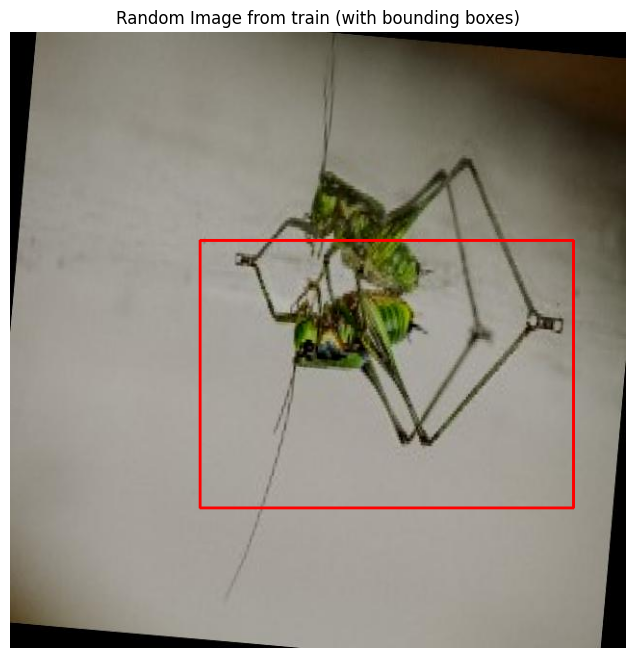

In [11]:
# run for any split: train / val / test
show_random_image_with_bbox("train")

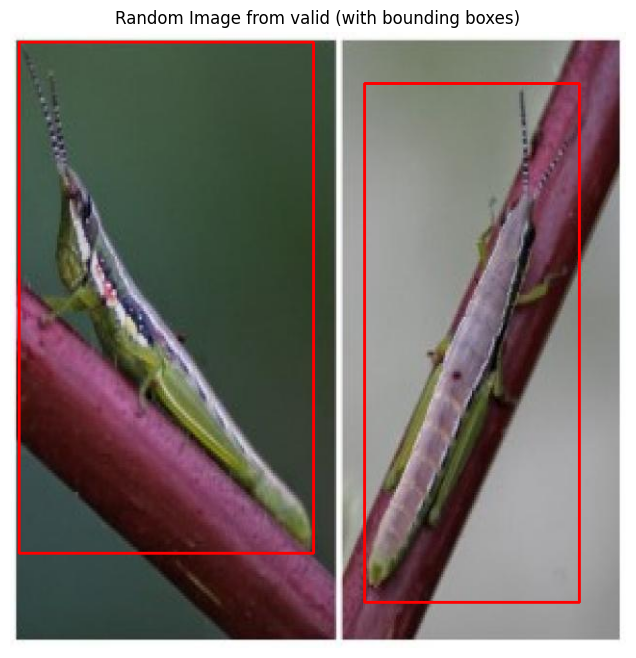

In [12]:
# run for any split: train / val / test
show_random_image_with_bbox("valid")

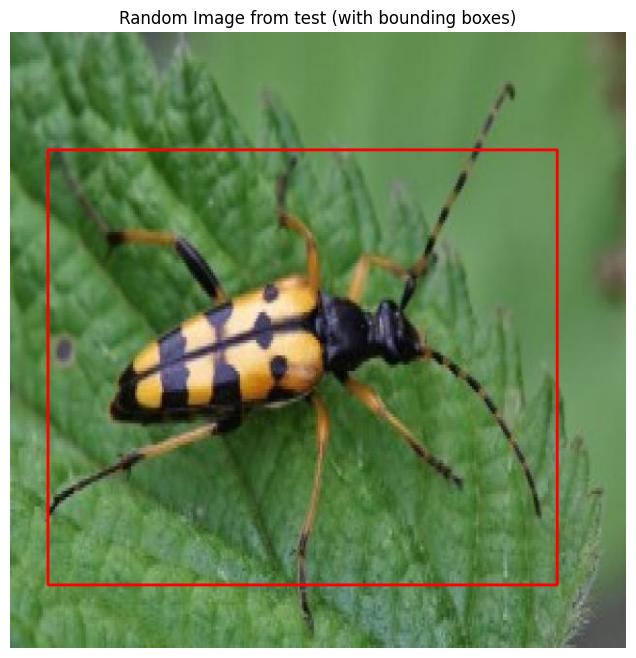

In [13]:
# run for any split: train / val / test
show_random_image_with_bbox("test")

In [14]:
def bbox_distribution(split):
    labels_path = dataset_path / split / "labels"
    bbox_per_image = []

    for lbl in os.listdir(labels_path):
        if lbl.endswith(".txt"):
            with open(labels_path / lbl, "r") as f:
                count = len(f.readlines())
                bbox_per_image.append(count)

    plt.figure(figsize=(8,5))
    plt.hist(bbox_per_image, bins=15)
    plt.title(f"Bounding Box Count Distribution ({split})")
    plt.xlabel("Number of Heads per Image")
    plt.ylabel("Number of Images")
    plt.show()

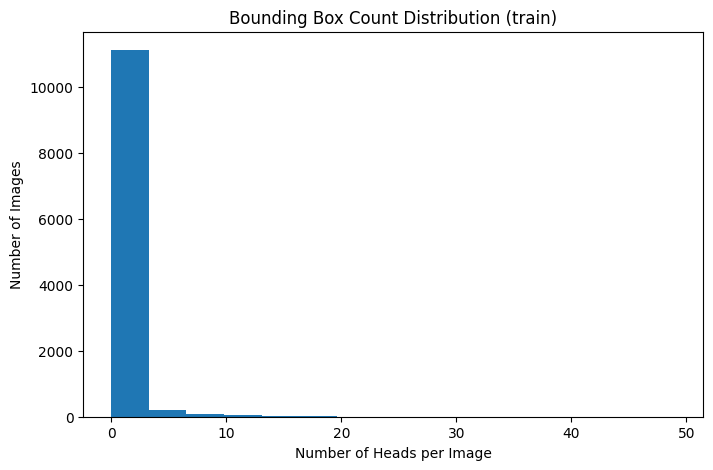

In [15]:
bbox_distribution("train")

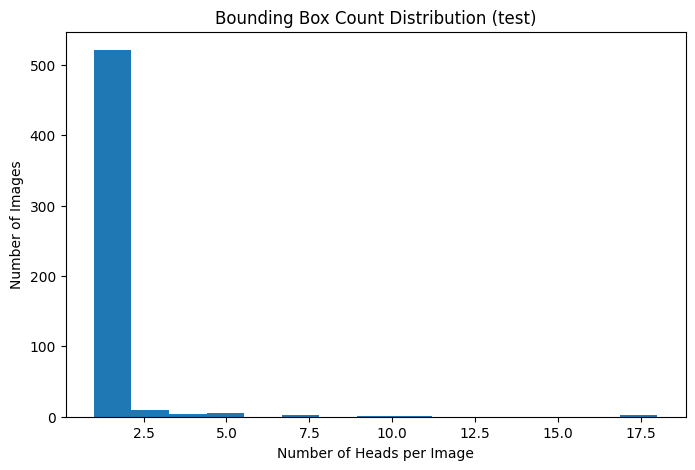

In [16]:
bbox_distribution("test")

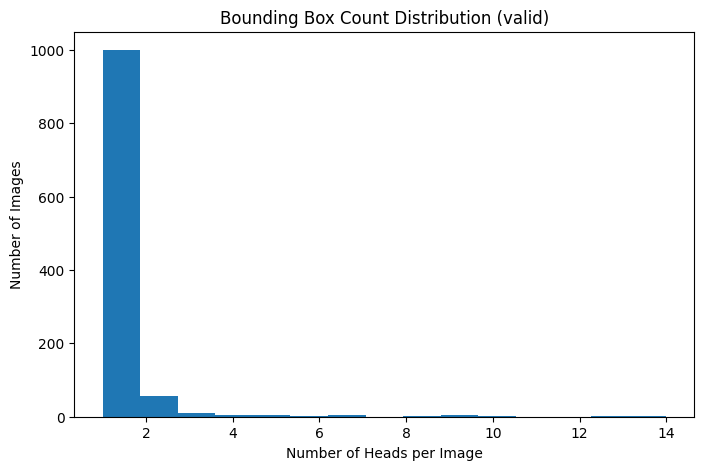

In [17]:
bbox_distribution("valid")

In [18]:
from PIL import Image
import numpy as np

def image_resolution_analysis(split):
    images_path = dataset_path / split / "images"

    widths, heights = [], []

    for img_name in os.listdir(images_path):
        img = Image.open(images_path / img_name)
        widths.append(img.size[0])
        heights.append(img.size[1])

    print(f"\n📌 {split.upper()} Image Resolution Summary")
    print("Avg Width :", int(np.mean(widths)))
    print("Avg Height:", int(np.mean(heights)))
    print("Min Width :", min(widths))
    print("Max Width :", max(widths))
    print("Min Height:", min(heights))
    print("Max Height:", max(heights))

image_resolution_analysis("train")
image_resolution_analysis("valid")
image_resolution_analysis("test")


📌 TRAIN Image Resolution Summary
Avg Width : 640
Avg Height: 640
Min Width : 640
Max Width : 640
Min Height: 640
Max Height: 640

📌 VALID Image Resolution Summary
Avg Width : 640
Avg Height: 640
Min Width : 640
Max Width : 640
Min Height: 640
Max Height: 640

📌 TEST Image Resolution Summary
Avg Width : 640
Avg Height: 640
Min Width : 640
Max Width : 640
Min Height: 640
Max Height: 640


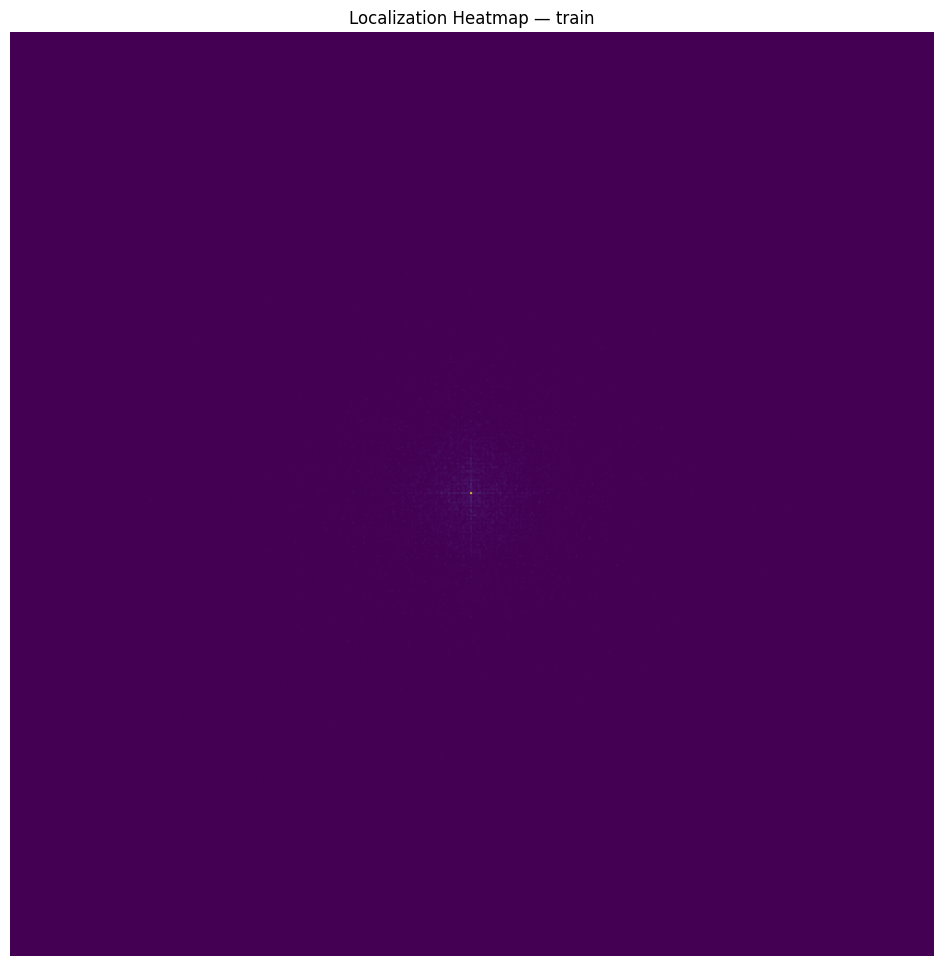

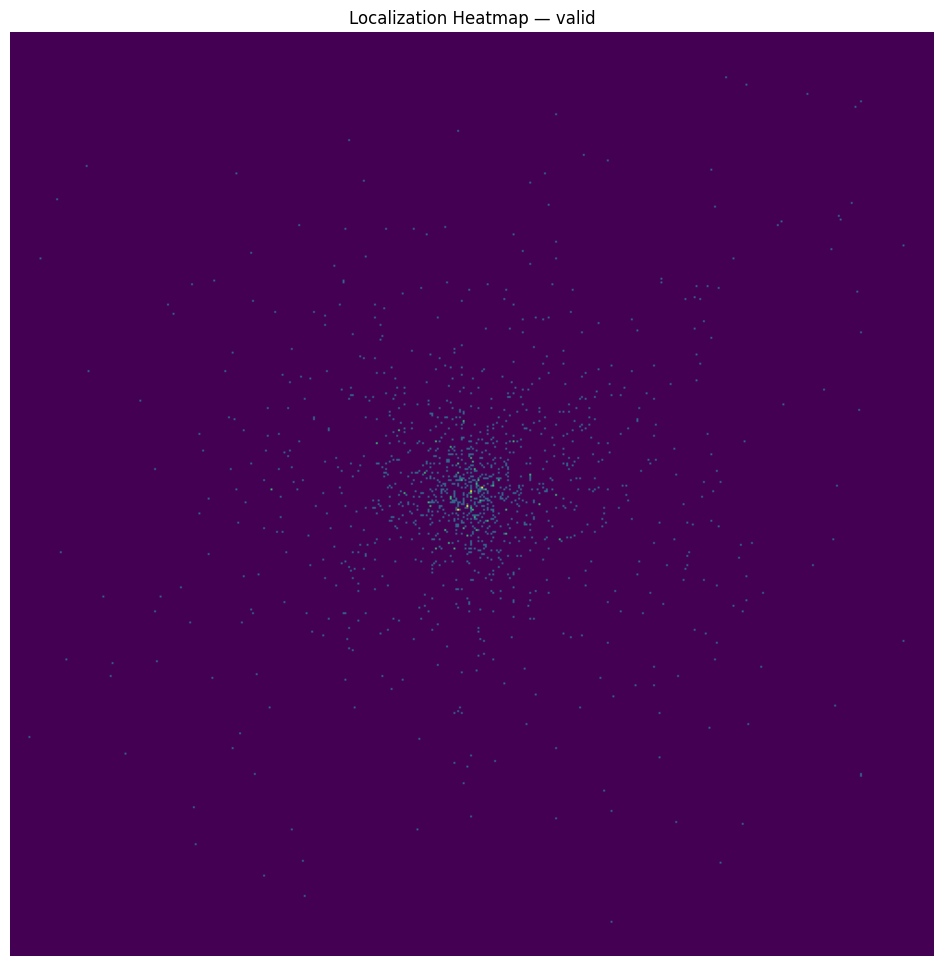

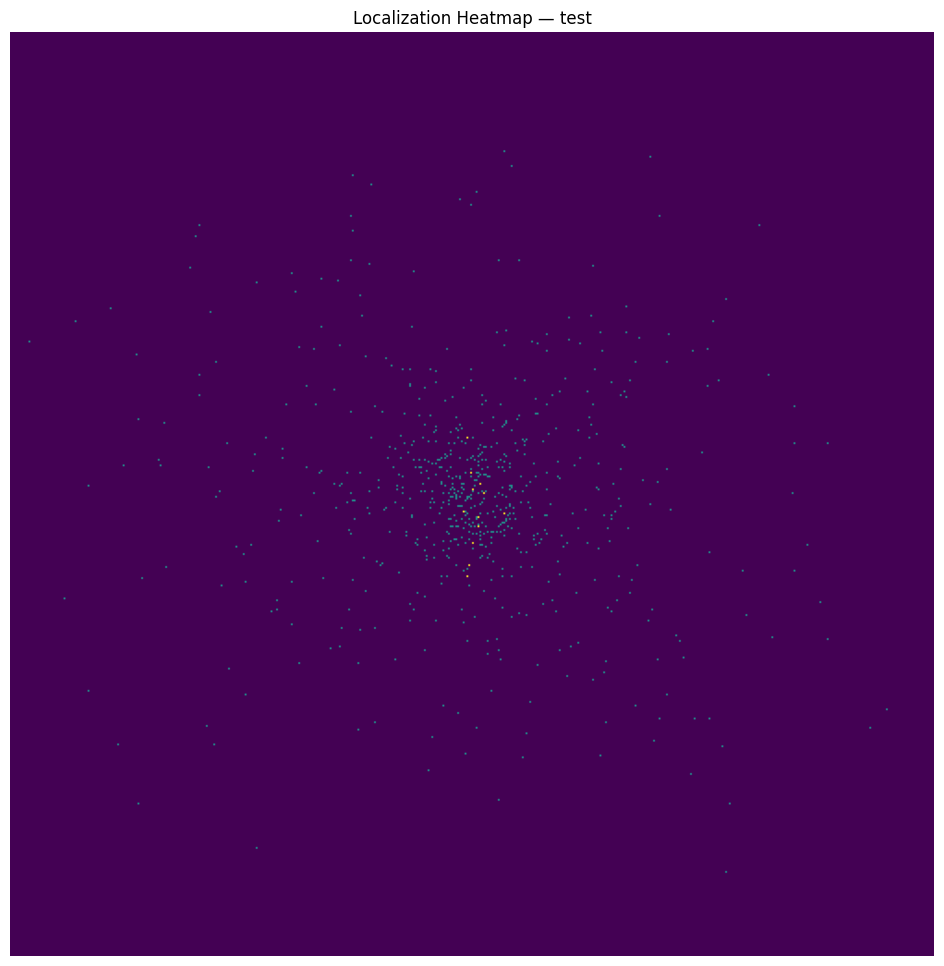

In [25]:
def bbox_heatmap(split):
    images_path = dataset_path / split / "images"
    labels_path = dataset_path / split / "labels"

    heatmap = np.zeros((500, 500))  # normalized map

    for lbl in os.listdir(labels_path):
        with open(labels_path / lbl) as f:
            for line in f.readlines():
                _, x, y, _, _ = map(float, line.split())
                px = int(x * 499)
                py = int(y * 499)
                heatmap[py, px] += 1

    plt.figure(figsize=(12,12))
    plt.imshow(heatmap)
    plt.title(f"Localization Heatmap — {split}")
    plt.axis("off")
    plt.show()

bbox_heatmap("train")
bbox_heatmap("valid")
bbox_heatmap("test")

In [20]:
def label_integrity_check(split):
    images_path = dataset_path / split / "images"
    labels_path = dataset_path / split / "labels"

    images = {f.split('.')[0] for f in os.listdir(images_path)}
    labels = {f.split('.')[0] for f in os.listdir(labels_path)}

    missing_labels = images - labels

    print(f"\n🛠 Integrity Check — {split}")
    print(f"Images with missing labels: {len(missing_labels)}")

    if missing_labels:
        print("\nExamples:")
        print(list(missing_labels)[:10])

label_integrity_check("train")
label_integrity_check("valid")
label_integrity_check("test")


🛠 Integrity Check — train
Images with missing labels: 0

🛠 Integrity Check — valid
Images with missing labels: 0

🛠 Integrity Check — test
Images with missing labels: 0


In [21]:
from collections import Counter

def class_distribution(split):
    labels_path = dataset_path / split / "labels"
    cls_counter = Counter()

    for lbl in os.listdir(labels_path):
        with open(labels_path / lbl) as f:
            for line in f.readlines():
                cls = int(line.split()[0])
                cls_counter[cls] += 1

    print(f"\n📊 Class distribution — {split}")
    print(dict(cls_counter))

class_distribution("train")
class_distribution("valid")
class_distribution("test")


📊 Class distribution — train
{1: 1596, 0: 2231, 2: 1058, 10: 1167, 3: 1740, 7: 1062, 4: 1083, 5: 1182, 6: 1071, 8: 918, 9: 1199, 11: 975}

📊 Class distribution — valid
{0: 178, 1: 110, 2: 100, 3: 139, 9: 107, 7: 101, 4: 72, 8: 91, 5: 104, 6: 102, 10: 132, 11: 105}

📊 Class distribution — test
{0: 87, 2: 44, 1: 44, 3: 93, 7: 47, 4: 40, 5: 73, 6: 55, 8: 51, 9: 50, 10: 47, 11: 58}


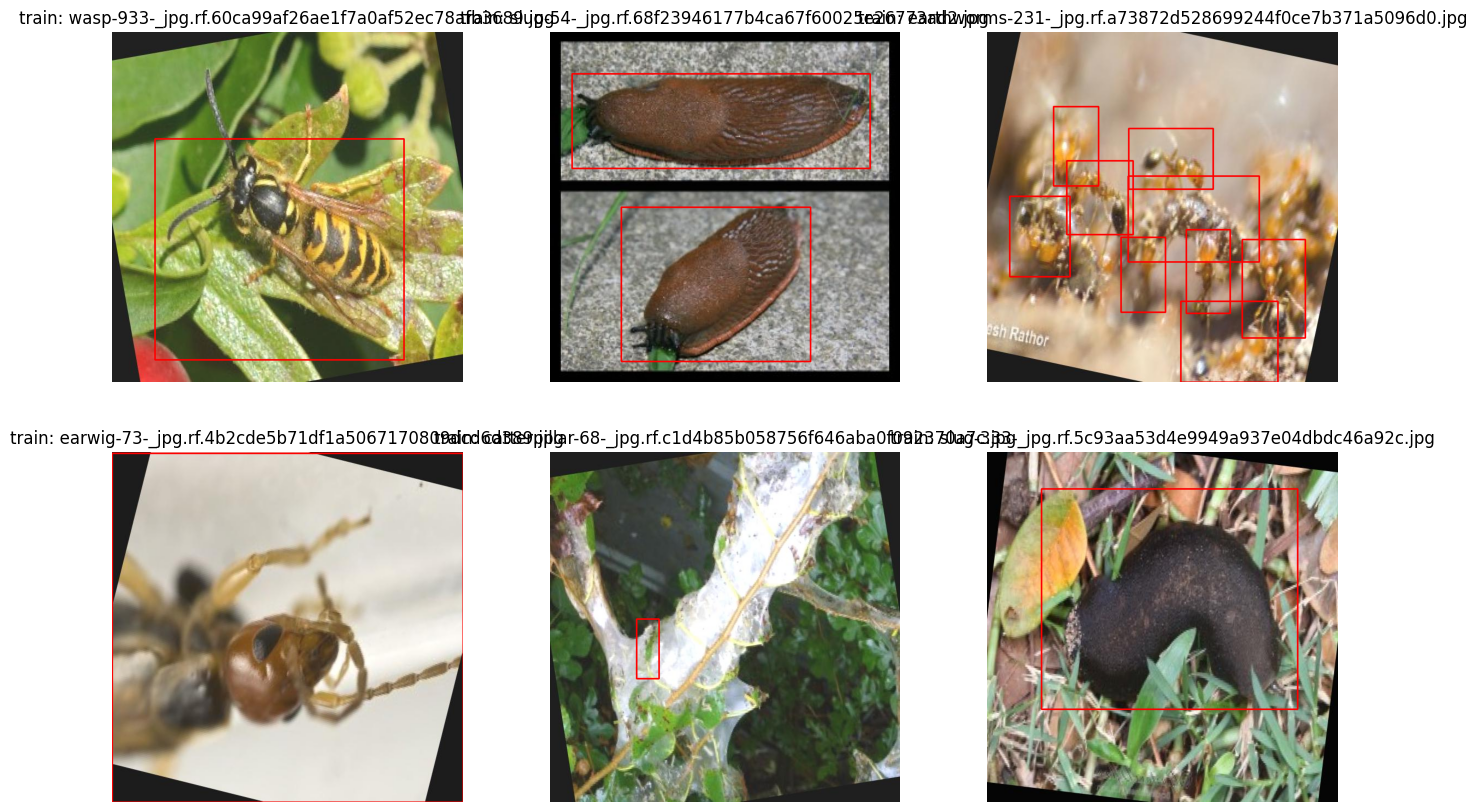

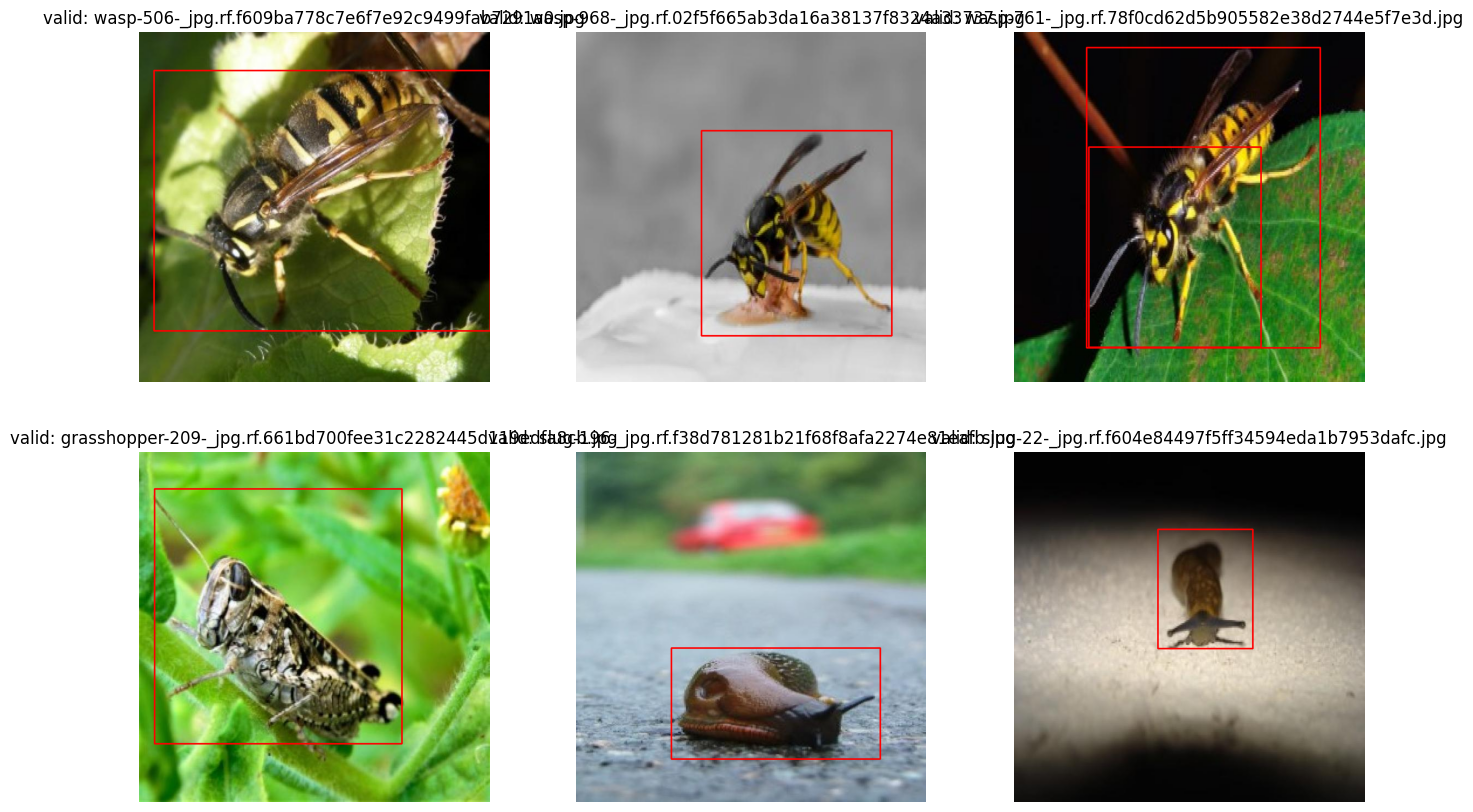

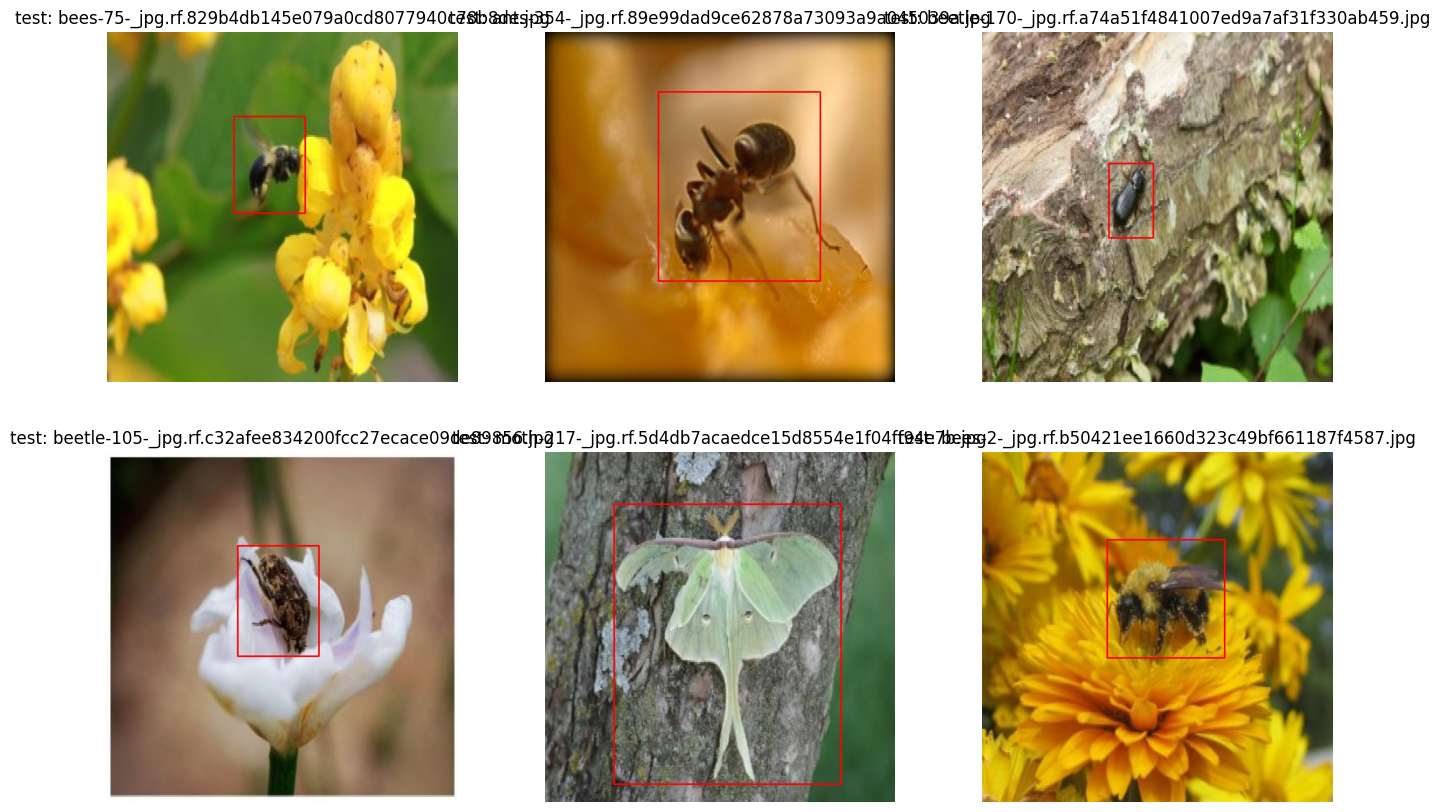

In [22]:
def visualize_with_heatmap(split):
    images_path = dataset_path / split / "images"
    labels_path = dataset_path / split / "labels"

    images = [f for f in os.listdir(images_path) if f.lower().endswith(image_extensions)]
    sample_images = random.sample(images, min(6, len(images)))

    # heatmap canvas (500x500 normalized)
    heatmap = np.zeros((500, 500))

    fig, ax = plt.subplots(2, 3, figsize=(16, 10))

    for i, img_name in enumerate(sample_images):
        img = cv2.imread(str(images_path / img_name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        h, w, _ = img.shape

        label_filename = img_name.rsplit(".", 1)[0] + ".txt"
        label_path = labels_path / label_filename

        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                for line in f.readlines():
                    cls, x_center, y_center, width, height = map(float, line.split())

                    # Calculate bounding box for image
                    x1 = int((x_center - width / 2) * w)
                    y1 = int((y_center - height / 2) * h)
                    x2 = int((x_center + width / 2) * w)
                    y2 = int((y_center + height / 2) * h)
                    cv2.rectangle(img, (x1, y1), (x2, y2), (255,0,0), 2)

                    # add to heatmap (normalized to 500x500)
                    px = int(x_center * 499)
                    py = int(y_center * 499)
                    heatmap[py, px] += 1

        ax[i//3, i%3].imshow(img)
        ax[i//3, i%3].axis("off")
        ax[i//3, i%3].set_title(f"{split}: {img_name}")

    plt.show()

# Run for train / val / test
visualize_with_heatmap("train")
visualize_with_heatmap("valid")
visualize_with_heatmap("test")

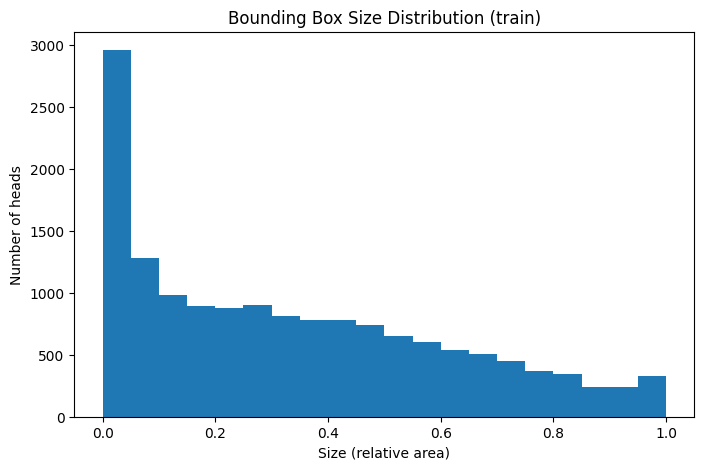

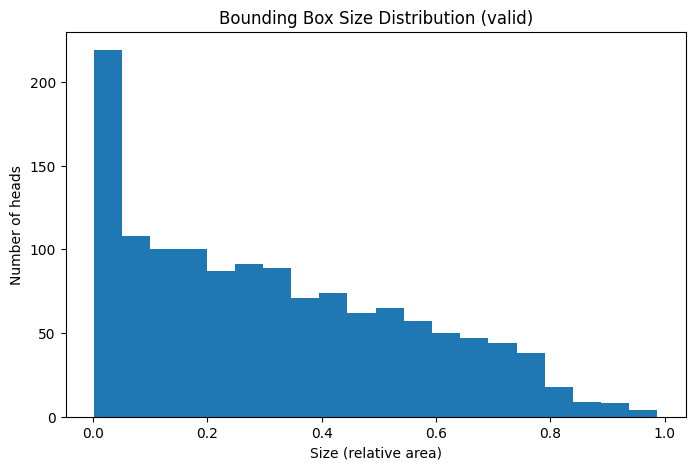

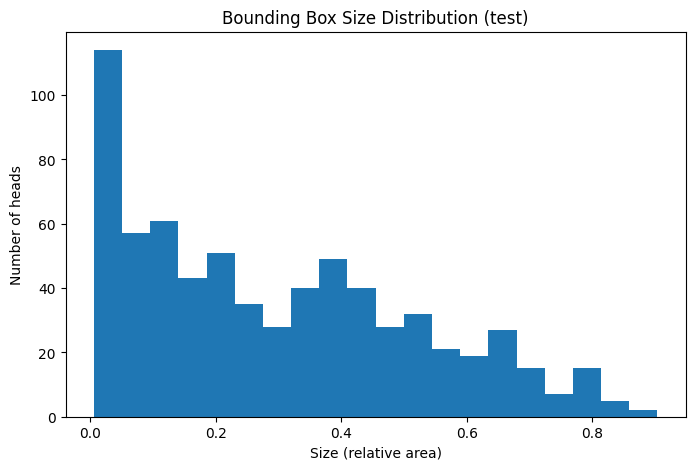

In [23]:
def bbox_size_distribution(split):
    labels_path = dataset_path / split / "labels"
    sizes = []

    for lbl in os.listdir(labels_path):
        if lbl.endswith(".txt"):
            with open(labels_path / lbl, "r") as f:
                for line in f.readlines():
                    _, _, _, w, h = map(float, line.split())
                    sizes.append(w * h)

    plt.figure(figsize=(8,5))
    plt.hist(sizes, bins=20)
    plt.title(f"Bounding Box Size Distribution ({split})")
    plt.xlabel("Size (relative area)")
    plt.ylabel("Number of heads")
    plt.show()

bbox_size_distribution("train")
bbox_size_distribution("valid")
bbox_size_distribution("test")

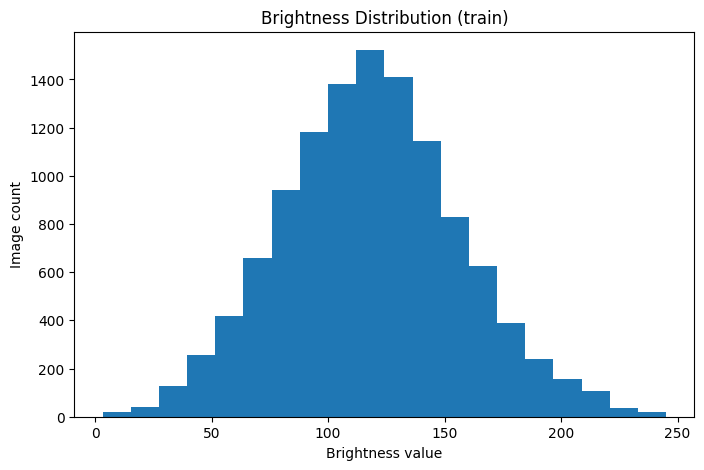

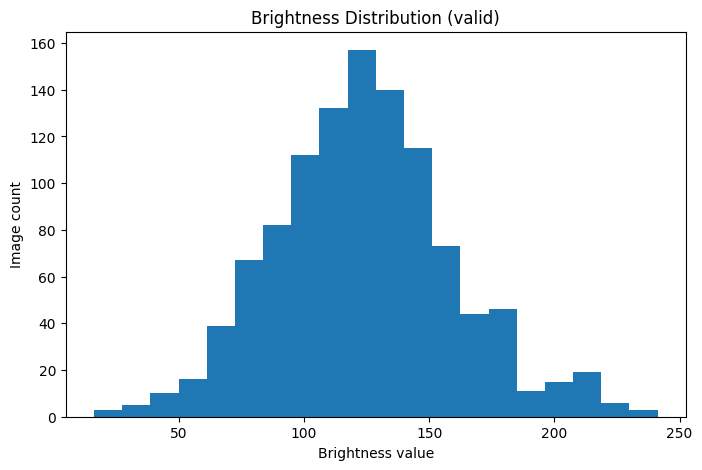

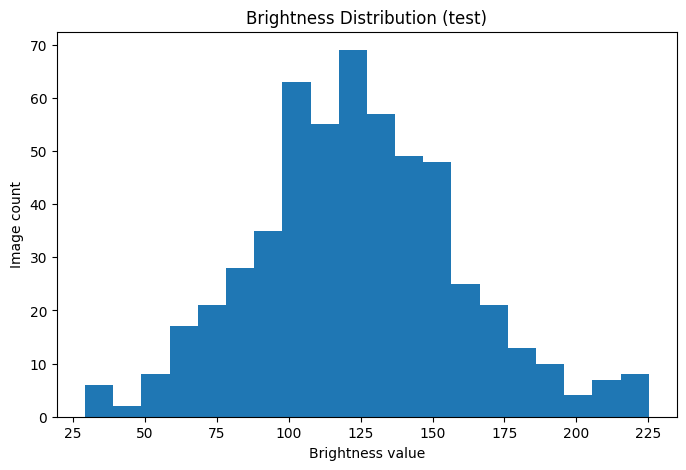

In [24]:
def brightness_analysis(split):
    images_path = dataset_path / split / "images"
    brightness_values = []

    for img_name in os.listdir(images_path):
        img = cv2.imread(str(images_path / img_name), cv2.IMREAD_GRAYSCALE)
        brightness_values.append(img.mean())

    plt.figure(figsize=(8,5))
    plt.hist(brightness_values, bins=20)
    plt.title(f"Brightness Distribution ({split})")
    plt.xlabel("Brightness value")
    plt.ylabel("Image count")
    plt.show()

brightness_analysis("train")
brightness_analysis("valid")
brightness_analysis("test")